In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from sklearn import neighbors
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Format data
Indicate the name of the data input csv file in the next cell.<br>
Data file must have both row and column headers, a row for each trial, and a column for each parameter.<br>
The last column must be for the classification, and must contain either the integer 0 or 1 only.

In [2]:
inputDataFileName = "ParameterData.csv"

In [3]:
# Load data into data frame, ignoring the 1st column of trial indices
with open(inputDataFileName) as f:
    ncols = len(f.readline().split(','))

parameterDF = pd.read_csv(inputDataFileName, delimiter=',', index_col=0, header=0 )

In [4]:
# Delete the indexing column and reset the indices
parameterDF = parameterDF.reset_index()
del parameterDF['index']

In [5]:
# Normalize the data
params = parameterDF.columns.tolist() # List of labels for indexing
normDF = DataFrame()

for param in params[:-1]: # Normalize each parameter column (not classification column)
    normalizedData = ( parameterDF[param] - parameterDF[param].mean() ) / parameterDF[param].std()
    normDF = pd.concat( [normDF, Series(normalizedData) ], axis=1 )
    normDF.rename( columns={ 0:param } )

# Add the classification column back in
normDF = pd.concat( [normDF, parameterDF[ params[-1] ] ], axis=1 )

In [6]:
# Group by classification
groups = normDF.groupby( normDF.columns[-1] )
successGroup = groups.get_group(1)
failureGroup = groups.get_group(0)

# Train the KNN classifiers
Enter the weighting method to use in the cell below.

In [7]:
weightMethod = 'distance' # Must be either 'distance', or 'uniform'

In [8]:
numParams = len(params)-1 # For looping through parameters
k = (int)( sqrt(parameterDF.shape[1]) ) # General starting point for k
if k%2 is 0: # But make k odd since there are 2 classifications and we don't want indeterminnant regions
    k += 1

In [9]:
classifiers = []
XTrains = []
XTests = []
yTrains = []
yTests = []
xMins = []
xMaxs = []
yMins = []
yMaxs = []

# Fit the classifiers
for rowNum in range(numParams):    
    for colNum in range(numParams):        
        if rowNum < colNum: # Exclude repeated plots       
            # Get data
            x1 = normDF[ params[colNum] ] # x-axis
            x2 = normDF[ params[rowNum] ] # y-axis
            X = np.column_stack( (x1, x2) )

            # Get overall min and max values for plotting and prediction testing
            xMin, xMax = x1.min(), x1.max() 
            yMin, yMax = x2.min(), x2.max()
            xMins.append(xMin), xMaxs.append(xMax), yMins.append(yMin), yMaxs.append(yMax)           
            
            # Split data into training and testing samples
            XTrain, XTest, yTrain, yTest = train_test_split(X, normDF[ params[-1] ])            
            XTrains.append(XTrain), XTests.append(XTest), yTrains.append(yTrain), yTests.append(yTest)
            
            # Fit the classifier
            classifier = neighbors.KNeighborsClassifier( k, weights=weightMethod ).fit(XTrain, yTrain)
            classifiers.append(classifier)

# Plot training data & prediction boundaries
Enter the step size to use for the prediction mesh in the cell below.

In [12]:
h = 0.1  # Step size in the prediction mesh 

In [13]:
colMap = ListedColormap( ['#F08080', '#98FB98'] ) # Prediction mesh colors
meshXs = []
meshYs = []
meshPredictions = []                
 
# Predict a meshgrid of data points
for num in range(len(classifiers)):    
    meshX, meshY = np.meshgrid(np.arange(xMins[num]-1, xMaxs[num]+1, h),
                               np.arange(yMins[num]-1, yMaxs[num]+1, h))
    meshXs.append(meshX), meshYs.append(meshY)
    meshPredicted = classifiers[num].predict(np.c_[meshX.ravel(), meshY.ravel()])
    meshPredicted = meshPredicted.reshape(meshX.shape)
    meshPredictions.append(meshPredicted)

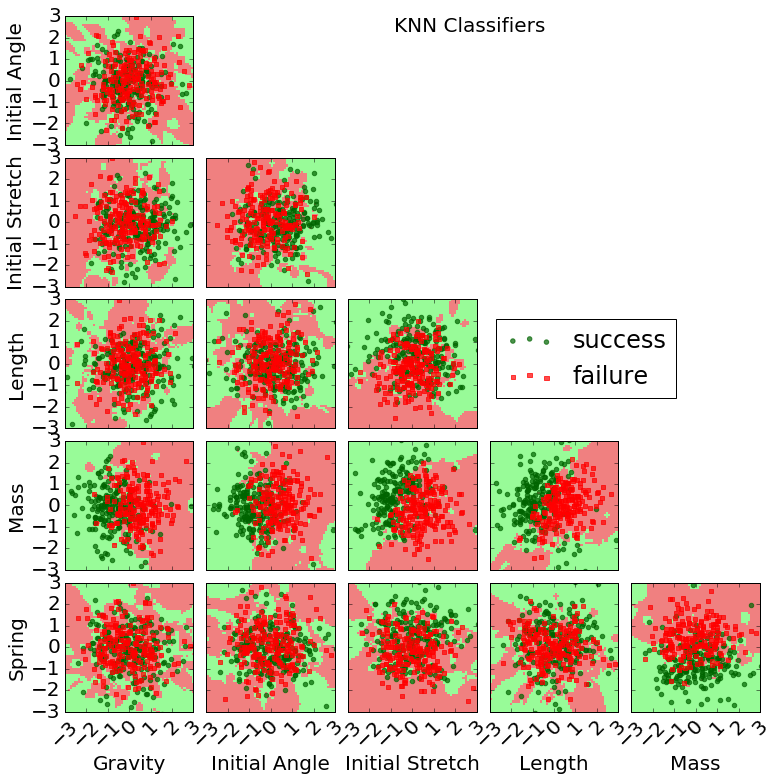

In [14]:
# Prepare the figure for plotting
plt.rcParams.update({'figure.autolayout': False})
plt.figure( figsize=(15,15) )
G = gridspec.GridSpec(numParams, numParams)
plt.subplots_adjust( hspace=0.1, wspace=0.1 ) 
plt.rc('font', size=20)
plt.suptitle('KNN Classifiers', x=0.5, y=0.9)
axarr = []
indices = [] # For indexing row and column labels

for xNum in range(numParams):
    for yNum in range(numParams):
        if xNum < yNum:
            indices.append( (params[xNum],params[yNum]) ) 
            ax = plt.subplot( G[yNum-1, xNum] )
            axarr.append(ax)
            if xNum is 0:
                plt.ylabel( params[yNum] )
            if xNum is not 0:
                plt.yticks( visible=False )
            if yNum is numParams-1:
                plt.xlabel( params[xNum] )
                plt.xticks( rotation=45 )
            if yNum is not numParams-1:
                plt.xticks( visible=False ) 

# Plot 
for num in range(len(indices)):                
    # Plot decision boundary
    axarr[num].pcolormesh(meshXs[num], meshYs[num], meshPredictions[num], cmap=colMap)
    
    # Plot the training data 
    xSuccesses = successGroup[ indices[num][1] ].head(200)
    ySuccesses = successGroup[ indices[num][0] ].head(200)
    axarr[num].scatter( xSuccesses, ySuccesses, marker='o', color='#006400', alpha=0.7, label='success' )
    
    xFailures = failureGroup[ indices[num][1] ].head(200)
    yFailures = failureGroup[ indices[num][0] ].head(200)
    axarr[num].scatter( xFailures, yFailures, marker='s', color='#FF0000', alpha=0.7, label='failure')
            
    axarr[num].set_xlim( -3,3 )
    axarr[num].set_ylim( -3,3 ) 

plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=-11)
plt.savefig('KNNPlot.png')
plt.show()

# Test prediction accuracy

In [15]:
accuracyScores = []
comparisons = []

# Create list of labels
for xNum in range(numParams):
    for yNum in range(numParams):
        if xNum < yNum:
            comparisons.append( params[xNum]+' vs '+params[yNum] ) 

In [16]:
# Predict test data and find accuracy
for num in range(len(classifiers)):
    predicted = classifiers[num].predict( XTests[num] )
    acc = accuracy_score( yTests[num], predicted )
    accuracyScores.append(acc)

C:\Users\dsarg\Anaconda3\envs\py35qt4\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


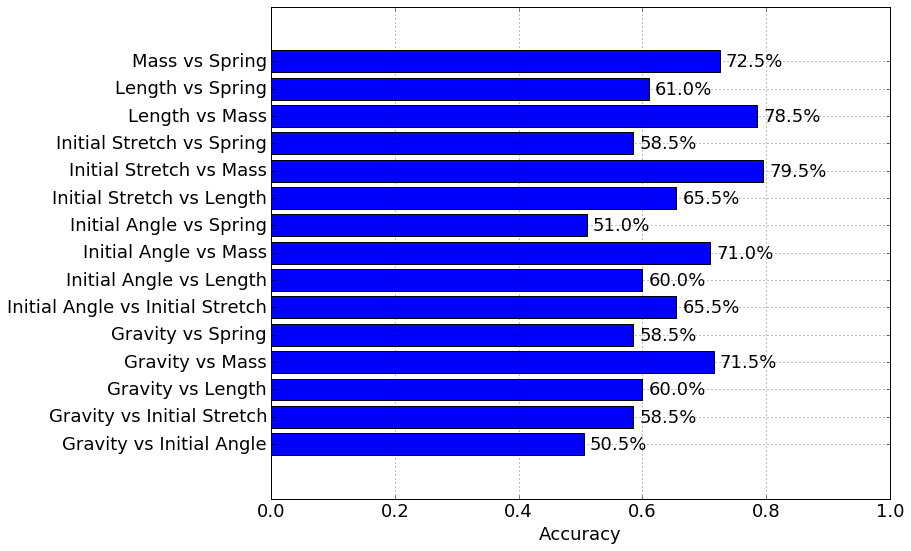

In [18]:
# Graph the accuracy (horizontal bar chart)
plt.rcParams.update({'figure.autolayout': True})
yAxis = np.arange(len(comparisons))
plt.rc('font', size=18)
plt.figure( figsize=(13,8) )
plt.barh(yAxis, accuracyScores, align='center')
for yPos, xPos in enumerate(accuracyScores):
    plt.gca().text(xPos+0.01, yPos-0.2, str( round(xPos*100,2) )+'%' )
plt.yticks(yAxis, comparisons)
plt.grid()
plt.xlim(0, 1.0)
plt.xlabel('Accuracy')
plt.savefig('KNN_Accuracy.png')
plt.show()